In [1]:
import os
from time import sleep

import matplotlib.pyplot as plt
import numpy as np

from pyaml.accelerator import Accelerator
from pyaml.common.constants import ACTION_RESTORE
from pyaml.magnet.magnet import Magnet

In [2]:
sr = Accelerator.load("p.yaml")
sr  # string representation

11 Feb% 2026, 14:15:52 | WARNING | PyAML Tango control system binding (0.3.3) initialized with name 'live' and TANGO_HOST=localhost:11000


Accelerator(facility='Synchrotron SOLEIL', machine='sr', energy=2750000000.0, controls=[TangoControlSystem(name='live', tango_host='localhost:11000', debug_level=None, lazy_devices=True, scalar_aggregator='tango.pyaml.multi_attribute', vector_aggregator=None, timeout_ms=3000)], simulators=[Simulator(name='design', lattice='SOLEIL_II_V3631_sym1_V001_database_rf.m', mat_key=None, linker=<pyaml.lattice.attribute_linker.PyAtAttributeElementsLinker object at 0x7c2074337500>, description=None)], data_folder='/data/store', description=None)

### Virtual accelerator setup for emulation of a control system
For the **live** control mode, you should have some control system emulation running. 

!!! *If you want to skip this, you can always run the notebook in **design** mode.* !!!

For the installation you should be able to do 
```
apptainer pull virtual-accelerator.sif oras://gitlab-registry.synchrotron-soleil.fr/software-control-system/containers/apptainer/virtual-accelerator:latest
apptainer run virtual-accelerator.sif
```
This will run SOLEIL II proof-of-concept digital twin on localhost:11000. You can play with the digital twin itself (without pyAML) via Jive to check that everything is working. You can run Jive in a different terminal with 
```
apptainer pull jive.sif https://gitlab.synchrotron-soleil.fr/api/v4/projects/2739/packages/generic/jive/latest/jive.sif
apptainer run jive.sif
```
On linux you may additionally configure X11
```
export DISPLAY=:0
xhost +local:root
```
Jive is not necessary to run anything but some of you may find it useful to open its `simulator/ringsimulator/ringsimulator` device on the side and see how the global parameters (tune, orbit, chromaticity, etc.) change with your actions in pyAML.
NOTE: This notebook is just a demonstration of pyAML functionality. Certain things may be done stupidly. The person who wrote this jupyter notebook only cared about showing that the code is working, not about intelligently controlling the accelerator.

In [3]:
control_mode = sr.design
control_mode

Simulator(name='design', lattice='SOLEIL_II_V3631_sym1_V001_database_rf.m', mat_key=None, linker=<pyaml.lattice.attribute_linker.PyAtAttributeElementsLinker object at 0x7c2074337500>, description=None)

In [4]:
bpms = control_mode.get_bpms("BPM")

#### Configuration

In the configuration file, the dipolar corrector magnets are not grouped in a family. We can simply look for the element names ending in 'hcorrector' or 'vcorrector' and create an array of magnets ourselves. In the configuration file, we also did not define neither the orbit response matrix nor the orbit correction tool. Everything can be defined manually if necessary.

In [5]:
hcorr_names = [
    mag.get_name()
    for mag in control_mode.get_all_magnets()
    if mag.get_name().endswith("hcorrector")
]
vcorr_names = [
    mag.get_name()
    for mag in control_mode.get_all_magnets()
    if mag.get_name().endswith("vcorrector")
]

control_mode.fill_magnet_array("HCORR", hcorr_names)
control_mode.fill_magnet_array("VCORR", vcorr_names)

In [6]:
from pyaml.tuning_tools.orbit_response_matrix import ConfigModel as ORM_ConfigModel
from pyaml.tuning_tools.orbit_response_matrix import OrbitResponseMatrix

orm = OrbitResponseMatrix(
    cfg=ORM_ConfigModel(
        name="DEFAULT_ORM",
        bpm_array_name="BPM",
        hcorr_array_name="HCORR",
        vcorr_array_name="VCORR",
        corrector_delta=1e-5,
    ),
)

control_mode.fill_device([orm])
orm = control_mode.get_orm_tuning("DEFAULT_ORM")

In [7]:
orm.measure(set_wait_time=0.01)

11 Feb% 2026, 14:17:54 | INFO | Measuring correctors from the default arrays: HCORR and VCORR.
11 Feb% 2026, 14:17:55 | INFO | Measured response of SH1_COR_001.hcorrector.
11 Feb% 2026, 14:17:56 | INFO | Measured response of SH2_HCOR_001.hcorrector.
11 Feb% 2026, 14:17:56 | INFO | Measured response of SXF11_HCOR_001.hcorrector.
11 Feb% 2026, 14:17:57 | INFO | Measured response of SXF1_HCOR_001.hcorrector.
11 Feb% 2026, 14:17:57 | INFO | Measured response of SXF13_HCOR_001.hcorrector.
11 Feb% 2026, 14:17:58 | INFO | Measured response of SXF13_HCOR_002.hcorrector.
11 Feb% 2026, 14:17:58 | INFO | Measured response of SXF1_HCOR_002.hcorrector.
11 Feb% 2026, 14:17:58 | INFO | Measured response of SXF12_HCOR_001.hcorrector.
11 Feb% 2026, 14:17:59 | INFO | Measured response of SH6_COR_001.hcorrector.
11 Feb% 2026, 14:17:59 | INFO | Measured response of SH4_COR_001.hcorrector.
11 Feb% 2026, 14:18:00 | INFO | Measured response of SH4_COR_002.hcorrector.
11 Feb% 2026, 14:18:00 | INFO | Measured 

In [8]:
ormdata = orm.get()

In [9]:
len(bpms), len(hcorr_names)

(180, 180)

Let's visualise the orbit response matrix

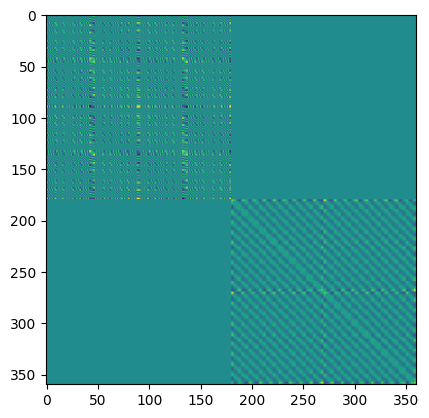

In [10]:
plt.imshow(np.array(ormdata["matrix"]))

In [9]:
# orm.save(f'orm_{control_mode}.json')

To have some orbit in the design mode we have to mangle it by introducing some noise on the H and V correctors. 

In [11]:
std_kick = 1e-6
hcorr = control_mode.get_magnets("HCORR")
vcorr = control_mode.get_magnets("VCORR")
bpms = control_mode.get_bpms("BPM")
ref_h, ref_v = control_mode.get_bpms("BPM").positions.get().T
reference = np.concat((ref_h, ref_v))
# mangle orbit
hcorr.strengths.set(
    hcorr.strengths.get() + std_kick * np.random.normal(size=len(hcorr))
)
vcorr.strengths.set(
    vcorr.strengths.get() + std_kick * np.random.normal(size=len(vcorr))
)

positions_bc = bpms.positions.get()
std_bc = np.std(positions_bc, axis=0)
sleep(2)
print(
    "R.m.s. orbit before correction "
    f"H: {1e6 * std_bc[0]: .1f} µm, V: {1e6 * std_bc[1]: .1f} µm."
)

R.m.s. orbit before correction H:  20.2 µm, V:  21.2 µm.


Let's visualise the mangled orbit before the correction is applied

Text(0, 0.5, 'Orbit')

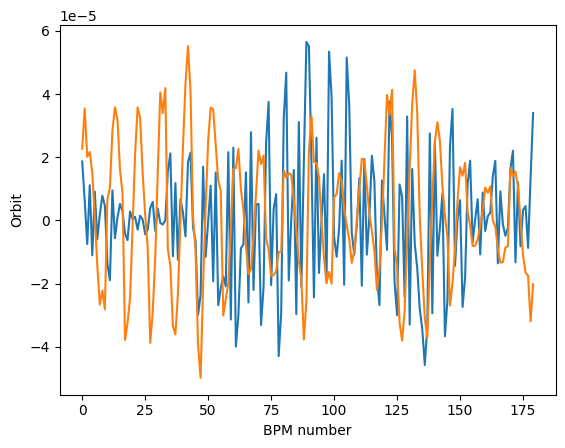

In [12]:
import matplotlib.pyplot as plt

plt.plot(positions_bc[:, 0], label="H")
plt.plot(positions_bc[:, 1], label="V")
plt.xlabel("BPM number")
plt.ylabel("Orbit")

### Dispersion measurement

In order to correct the orbit we would also need to know the rf response of our machine. For this we will measure dispersion.

In [13]:
sr.design.get_lattice().enable_6d()
control_mode = sr.design

In [14]:
from pyaml.tuning_tools.dispersion import ConfigModel as Disp_ConfigModel
from pyaml.tuning_tools.dispersion import Dispersion

dispersion = Dispersion(
    cfg=Disp_ConfigModel(
        name="DEFAULT_DISPERSION",
        bpm_array_name="BPM",
        rf_plant_name="RF",
        frequency_delta=500,
    ),
)

control_mode.fill_device([dispersion])
dispersion = control_mode.get_dispersion_tuning("DEFAULT_DISPERSION")

In [15]:
dispersion.measure(set_waiting_time=0.5)
dispersion_data = dispersion.get()

In [16]:
rf_response = (
    dispersion_data["frequency_response_x"] + dispersion_data["frequency_response_y"]
)
dispersion_data.keys()

dict_keys(['raw_orbit_x_up', 'raw_orbit_y_up', 'raw_orbit_x_center', 'raw_orbit_y_center', 'raw_orbit_x_down', 'raw_orbit_y_down', 'raw_orbit_x_err_up', 'raw_orbit_y_err_up', 'raw_orbit_x_err_center', 'raw_orbit_y_err_center', 'raw_orbit_x_err_down', 'raw_orbit_y_err_down', 'frequency_response_x', 'frequency_response_y', 'frequency_response_x_err', 'frequency_response_y_err', 'delta', 'momentum_compaction', 'shots_per_orbit', 'bipolar', 'timestamp', 'original_save_path'])

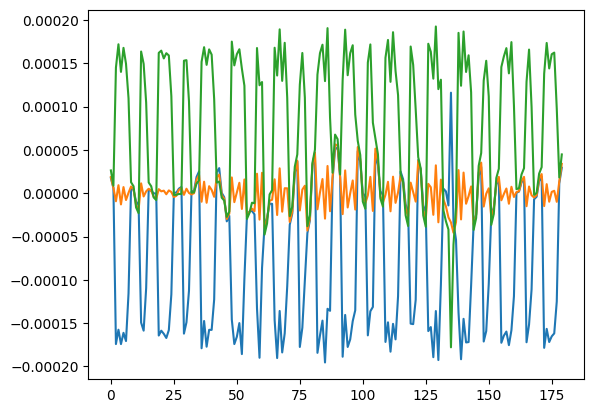

In [17]:
plt.plot(dispersion_data["raw_orbit_x_up"])
plt.plot(dispersion_data["raw_orbit_x_center"])
plt.plot(dispersion_data["raw_orbit_x_down"])

Now we can construct the response matrix

In [18]:
from pyaml.tuning_tools.orbit import ConfigModel as OrbitConfigModel
from pyaml.tuning_tools.orbit import Orbit

In [19]:
from pyaml.tuning_tools.response_matrix import ConfigModel as ResponseMatrixCondigModel
from pyaml.tuning_tools.response_matrix import ResponseMatrix

In [22]:
ormdata.keys()

dict_keys(['matrix', 'matrix_err', 'inputs_delta', 'shots_per_orbit', 'bipolar', 'raw_up', 'raw_center', 'raw_down', 'raw_err_up', 'raw_err_center', 'raw_err_down', 'reference', 'reference_err', 'input_names', 'output_names', 'last_input', 'last_number', 'timestamp', 'original_save_path', 'inputs_plane', 'outputs_plane'])

In [23]:
rest_mat = ResponseMatrix(
    ResponseMatrixCondigModel(
        matrix=ormdata["matrix"],
        input_names=ormdata["input_names"],
        output_names=ormdata["output_names"],
        rf_response=rf_response,
    )
)

In [24]:
orbit = Orbit(
    OrbitConfigModel(
        name="DEFAULT_ORBIT",
        bpm_array_name="BPM",
        hcorr_array_name="HCORR",
        vcorr_array_name="VCORR",
        singular_values=180,
        response_matrix=rest_mat,
    )
)

In [25]:
control_mode = sr.design

In [26]:
control_mode.fill_device([orbit])
orbit = control_mode.get_orbit_tuning("DEFAULT_ORBIT")
orbit.post_init()

11 Feb% 2026, 14:32:13 | INFO | (Re-)Building pseudoinverse RM with method='svd_values' and parameter=180 with zerosum=True.
11 Feb% 2026, 14:32:14 | INFO | (Re-)Building pseudoinverse RM with method='svd_values' and parameter=180 with zerosum=False.


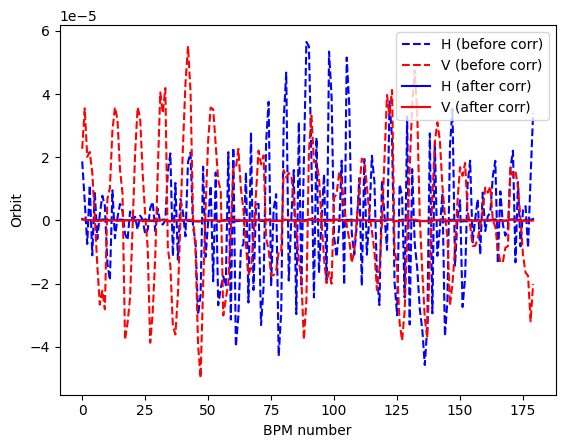

In [27]:
plt.plot(positions_bc[:, 0], label="H (before corr)", color="b", ls="--")
plt.plot(positions_bc[:, 1], label="V (before corr)", color="r", ls="--")

orbit.correct(reference=reference)

positions_after = bpms.positions.get()
plt.plot(positions_after[:, 0], label="H (after corr)", color="b", ls="-")
plt.plot(positions_after[:, 1], label="V (after corr)", color="r", ls="-")

plt.xlabel("BPM number")
plt.ylabel("Orbit")
plt.legend()